# Ensemble Learning

## Initial Imports

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [12]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head(5)

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [ ]:
# Label Encode X - homeowner

label_encoder = LabelEncoder()
label_encoder.fit(df["homeowner"])
list(label_encoder.classes_)
df["homeowner"] = label_encoder.transform(df["homeowner"])
df.head(5)


In [16]:
df1 = df.select_dtypes(include=['object'])
df1

,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,initial_list_status,next_pymnt_d,application_type,hardship_flag,debt_settlement_flag
0,RENT,Source Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
1,MORTGAGE,Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
2,MORTGAGE,Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
3,RENT,Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
4,MORTGAGE,Not Verified,Mar-2019,low_risk,n,w,May-2019,Individual,N,N
...,...,...,...,...,...,...,...,...,...,...
68812,RENT,Source Verified,Jan-2019,low_risk,n,w,May-2019,Individual,N,N
68813,RENT,Not Verified,Jan-2019,low_risk,n,w,May-2019,Individual,N,N
68814,MORTGAGE,Source Verified,Jan-2019,low_risk,n,w,May-2019,Individual,N,N
68815,MORTGAGE,Verified,Jan-2019,low_risk,n,f,May-2019,Individual,N,N


In [17]:


obj_df = df.select_dtypes(include=['object'])
map_dict = {col: {n: cat for n, cat in enumerate(obj_df[col].astype('category').cat.categories)} for col in obj_df}
#eer_style_dict = {value:key for key, value in convert_cats['beer_style'].items()}
obj_df = pd.DataFrame({col: obj_df[col].astype('category').cat.codes for col in obj_df}, index=obj_df.index)
obj_df.head(10)




,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,initial_list_status,next_pymnt_d,application_type,hardship_flag,debt_settlement_flag
0,3,1,2,1,0,1,1,0,0,0
1,1,2,2,1,0,1,1,0,0,0
2,1,2,2,1,0,1,1,0,0,0
3,3,2,2,1,0,1,1,0,0,0
4,1,0,2,1,0,1,1,0,0,0
5,1,1,2,1,0,1,1,0,0,0
6,3,1,2,1,0,1,1,0,0,0
7,2,1,2,1,0,1,1,0,0,0
8,3,0,2,1,0,0,1,0,0,0
9,3,2,2,1,0,1,1,0,0,0


In [18]:
categorical_vars = list(df.columns[df.dtypes == object].values)
categorical_vars

['home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'initial_list_status',
 'next_pymnt_d',
 'application_type',
 'hardship_flag',
 'debt_settlement_flag']

In [21]:
df.drop(categorical_vars,axis=1,inplace=True)

In [24]:
df = pd.concat([df,obj_df],axis=1)

## Split the Data into Training and Testing

In [25]:
# Create our features
X = df.copy()
X.drop("loan_status", axis=1, inplace=True)
X.head()



,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,total_il_high_credit_limit,home_ownership,verification_status,issue_d,pymnt_plan,initial_list_status,next_pymnt_d,application_type,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,61987.0,3,1,2,0,1,1,0,0,0
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,49197.0,1,2,2,0,1,1,0,0,0
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,43144.0,1,2,2,0,1,1,0,0,0
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,76506.0,3,2,2,0,1,1,0,0,0
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,20000.0,1,0,2,0,1,1,0,0,0


In [28]:
# Create our target
y = df["loan_status"].values
#y = df["loan_status"].values.reshape(-1, 1)
y[:5]


array([1, 1, 1, 1, 1], dtype=int8)

In [29]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,total_il_high_credit_limit,home_ownership,verification_status,issue_d,pymnt_plan,initial_list_status,next_pymnt_d,application_type,hardship_flag,debt_settlement_flag
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,5.572240e+04,1.812779,0.669994,0.805542,0.0,0.876121,0.616839,0.139660,0.0,0.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,5.095845e+04,0.941313,0.719105,0.714932,0.0,0.329446,0.486161,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,1.270000e+02,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,2.288000e+04,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,4.200000e+04,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.0,0.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,7.249900e+04,3.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.0,0.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.426964e+06,3.000000,2.000000,2.000000,0.0,1.000000,1.000000,1.000000,0.0,0.0


In [32]:
# Check the balance of our target values
# YOUR CODE HERE

df["loan_status"].value_counts()

1    68470
0      347
Name: loan_status, dtype: int64

In [34]:
# Split the X and y into X_train, X_test, y_train, y_test
# YOUR CODE HERE

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)


## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [35]:
# Create the StandardScaler instance
# YOUR CODE HERE

scaler = StandardScaler()


In [36]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
# YOUR CODE HERE

X_scaler = scaler.fit(X_train)



In [37]:
# Scale the training and testing data
# YOUR CODE HERE

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [38]:
# Resample the training data with the BalancedRandomForestClassifier
# YOUR CODE HERE

from imblearn.ensemble import BalancedRandomForestClassifier

rf_model = BalancedRandomForestClassifier(n_estimators=500, random_state=1)


In [40]:
# Fit and Train the Model

rf_model = rf_model.fit(X_train_scaled, y_train)
predictions = rf_model.predict(X_test_scaled)

In [44]:
# Display the confusion matrix
# YOUR CODE HERE

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [45]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,56,36
Actual 1,1641,15472


Accuracy Score : 0.9025283347863993
Classification Report
              precision    recall  f1-score   support

           0       0.03      0.61      0.06        92
           1       1.00      0.90      0.95     17113

    accuracy                           0.90     17205
   macro avg       0.52      0.76      0.51     17205
weighted avg       0.99      0.90      0.94     17205



In [55]:
# Calculated the balanced accuracy score
# YOUR CODE HERE


from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, predictions)

0.7564018201265755

In [61]:
# Print the imbalanced classification report
# YOUR CODE HERE

from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.07      0.93      0.94      0.14      0.94      0.88        92
          1       1.00      0.94      0.93      0.97      0.94      0.88     17113

avg / total       0.99      0.94      0.93      0.96      0.94      0.88     17205



<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

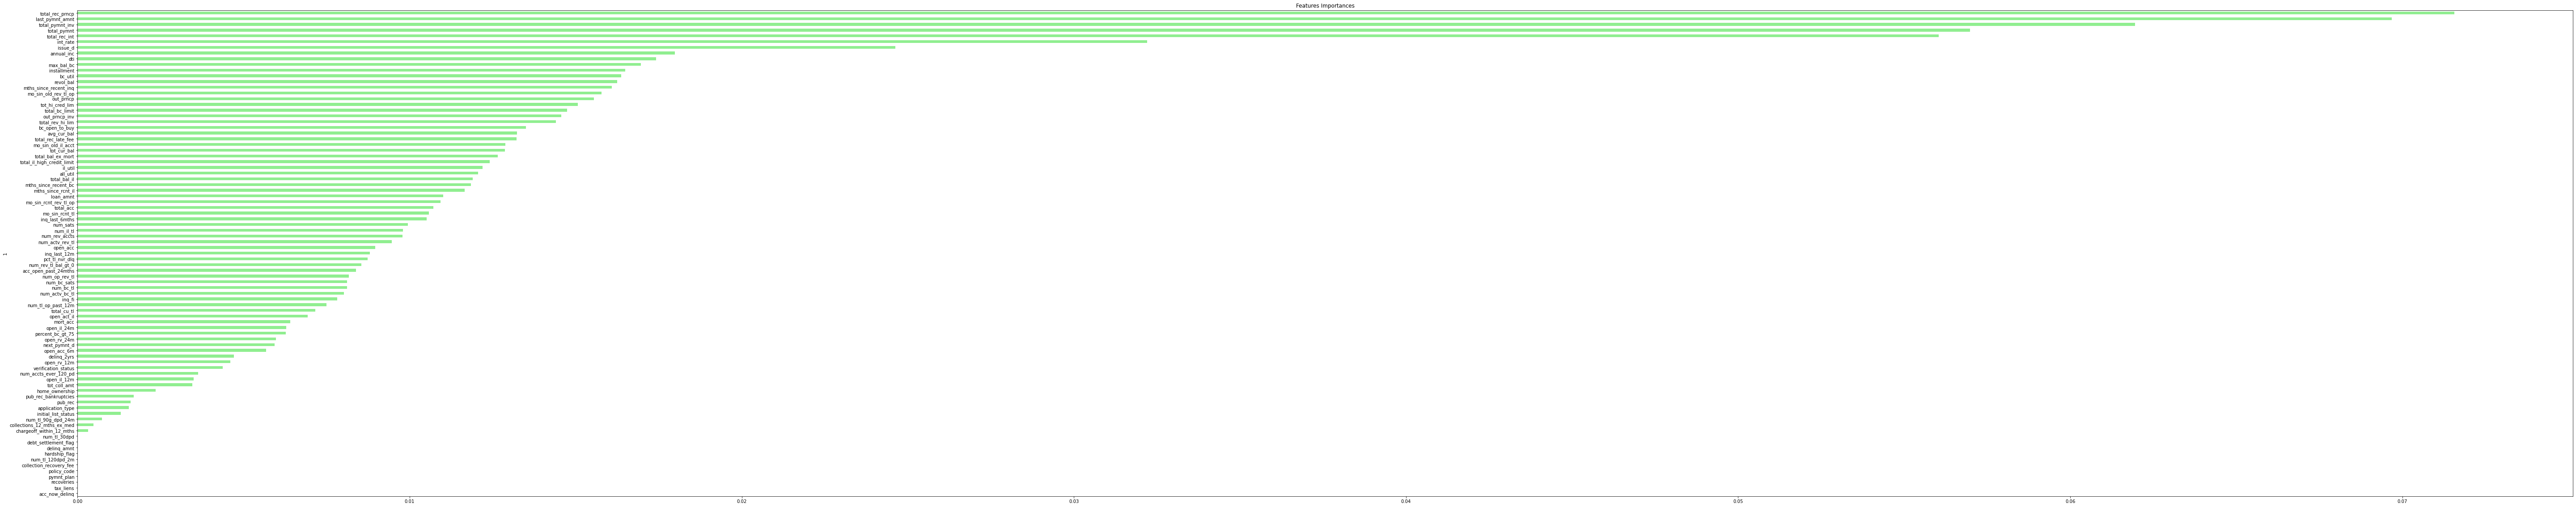

In [49]:
# List the features sorted in descending order by feature importance
# YOUR CODE HERE

# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, figsize = (100,20))



### Easy Ensemble Classifier

In [56]:
# Train the Classifier
# YOUR CODE HERE

from imblearn.ensemble import EasyEnsembleClassifier

rf_model = EasyEnsembleClassifier(n_estimators=500, random_state=1)


In [57]:
# Fit and Train the Model

rf_model = rf_model.fit(X_train_scaled, y_train)
predictions = rf_model.predict(X_test_scaled)


In [62]:
# Display the confusion matrix
# YOUR CODE HERE

# Display the confusion matrix
# YOUR CODE HERE

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [63]:
# Print Confusion Matrix

print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,86,6
Actual 1,1089,16024


Accuracy Score : 0.9363557105492589
Classification Report
              precision    recall  f1-score   support

           0       0.07      0.93      0.14        92
           1       1.00      0.94      0.97     17113

    accuracy                           0.94     17205
   macro avg       0.54      0.94      0.55     17205
weighted avg       0.99      0.94      0.96     17205



In [64]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, predictions)


0.9355733881437707

In [65]:
# Print the imbalanced classification report
# YOUR CODE HERE

from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, predictions))


                   pre       rec       spe        f1       geo       iba       sup

          0       0.07      0.93      0.94      0.14      0.94      0.88        92
          1       1.00      0.94      0.93      0.97      0.94      0.88     17113

avg / total       0.99      0.94      0.93      0.96      0.94      0.88     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    YOUR ANSWER HERE.

2. Which model had the best recall score?

    YOUR ANSWER HERE.

3. Which model had the best geometric mean score?

    YOUR ANSWER HERE.

4. What are the top three features?

    YOUR ANSWER HERE.

In [59]:
# Which model had the best balanced accuracy score?

# YOUR ANSWER HERE.

# Which model had the best recall score?

# YOUR ANSWER HERE.

# Which model had the best geometric mean score?

# YOUR ANSWER HERE.

# What are the top three features?

# YOUR ANSWER HERE.